# Naïve Bayes Practical


In today's practical we will develop, train and evaluate a Naive Bayes classifier from scratch. 
First of all let's import pandas

In [87]:
import pandas as pd

## The dataset

The data set we will use for this practical is the Adult data set from the UCI Machine Learning Repository.

With this data set we'll build a classifier for classifying adult Americans to those with an annual salary of at most \\$50,000 ("<=50K") and those above \\$50,000 (">50K"). Look at the [website for the Adult data](https://archive.ics.uci.edu/ml/datasets/adult) set to understand it more.



In [89]:
training = pd.read_csv("DatasetsForPracticals/NaivePractical/adult_data.csv",na_values="?",skipinitialspace=True)

Use `training.head()`, `training.describe(include='all')`, `training.info()` to get an idea of the data in hand. Using `include='all'` in `describe` lets you see both categorical and continuous variables. 


In [1]:
# Insert your code here


The method `pd.crosstab()` or `.value_counts()` can be used to look at classes that you're particularly interested in. In this case, our label will be `salary` so have a look at how many instances you have from each class:

In [2]:
# Insert your code here


Notice that the salary class in the training set is heavily biased towards <=50K. Spend a few minutes further understanding the data. What is the _a priori_ probability of class '<=50K'? What is the _a priori_ probability of class '>50K'?

In [92]:
# Insert your code here

col_0,count
salary,
<=50K,0.75919
>50K,0.24081


## Naïve Bayes classifier

Recall that to implement a Naive Bayes we’d use the following equation for each class to determine which class has highest probability of occurring given the feature data:

$$p(c_i|x)\propto p(c_i)p(x_1|c_i)p(x_2|c_i)\ldots p(x_n|c_i)$$

So, we need to determine the _a priori_ probability, $p(c_i)$, of each class occurring. Assuming our training set is representative then this is easily done and can be achieved by using either the `pd.crosstab()` function or `value_counts()` and `unstack()`.

In [93]:
table=pd.DataFrame(pd.crosstab(training['education'],training['salary']))
table
# or 
#training[['education','salary']].value_counts().unstack(fill_value=0)

salary,<=50K,>50K
education,,
10th,871,62
11th,1115,60
12th,400,33
1st-4th,162,6
5th-6th,317,16
7th-8th,606,40
9th,487,27
Assoc-acdm,802,265
Assoc-voc,1021,361


We can use the same table to get the numbers we need for calculating $p(x_{\textrm{education}}|c_i)$.

How do we get the corresponding probabilities from this table? That's actually all we need to compute the probabilities of interest. For instance, how could you calculate the probability of someone having an education level '10th' given that they're earning '>50k',  i.e., $p(x_{\textrm{education}}=10th|c_i='>50k')$ ?

In [94]:
# Insert your code here


0.007907154699655656

Look at the code in the function `classifier1.py` that uses the education feature.

Make sure you understand the code. It's recommended that you run parts of the code here and look at the output to make sure you understand what's going on.

In [95]:
# Data tables that are needed
salary_table = training['salary'].value_counts()
educationSalary_table=pd.DataFrame(pd.crosstab(training['education'],training['salary']))


# Classifier function
# Input
#    x: vector of feature values
#    printPosteriorProbs: if True then prints the class probabilities
# Output
#    result: classification result and class probabilities

def classifier1(x, printProbs=False):
    # We start with the a-priori probabilities of salary
    salaryProbs = salary_table/sum(salary_table)
    # prior p(Salary<=50K)
    lowSalaryPrior = salaryProbs["<=50K"]
    # prior p(Salary>50K)
    highSalaryPrior = salaryProbs[">50K"]
    
    #Education: We use the conditional probabilities of Education level given salary level
    education=x['education']
    
    # p(Salary= less50k| education level) ~= p(salary=less50k)*p(education level|salary=less50k)
    lowSalaryProb = lowSalaryPrior * educationSalary_table.loc[education,"<=50K"]/educationSalary_table.loc[:,"<=50K"].sum()
    
    # p(Salary= greater50k| education level) ~= p(salary=greater50k)*p(education level|salary=greater50k)
    highSalaryProb = highSalaryPrior * educationSalary_table.loc[education,">50K"]/educationSalary_table.loc[:,">50K"].sum()

    if printProbs:
        print("<=50K: ",lowSalaryProb,">50K:",highSalaryProb)
        
    # Decide on the result
    result = ">50K" if highSalaryProb > lowSalaryProb else "<=50K"
    return pd.Series((result, lowSalaryProb, highSalaryProb))

Test the function to ensure it produces the following results for the training instances 1 and 6. How would you classify these two instances?


In [96]:
#Insert your code here


<=50K:  0.09625011516845305 >50K: 0.06821043579742637
0      <=50K
1    0.09625
2    0.06821
dtype: object
===
<=50K:  0.023463652836215106 >50K: 0.029452412395196706
0        >50K
1    0.023464
2    0.029452
dtype: object


Now let's apply the classifier to the whole test set and analyse the result:

In [97]:
test=pd.read_csv("DatasetsForPracticals/NaiveBayesPractical/adult_test.csv",na_values="?",skipinitialspace=True)

In [98]:
predictions=test.apply(classifier1,axis=1)
predictions.columns=['predClass','<=50K','>50K']

Let's create the confusion matrix:

In [99]:
cm=pd.crosstab(predictions.predClass,test.salary,colnames=['Actual'],rownames=['Predicted'])
cm

Actual,<=50K,>50K
Predicted,,
<=50K,11881,3027
>50K,554,819


Using this table, can you calculate measures such as accuracy, TPR, FPR, etc.? Assume that ">50K" is the positive class.

In [100]:
#Insert your code/answer here



0.7800503654566673
0.21294851794071762
0.04455166867712103


If we consider ">50K" as the positive class then the true positive rate is $819/(3027+819)=21.3\%$ and the false positive rate is $554/(11881+554) = 4.5\%$. This seems very low true positive rate. Maybe using more features will improve matters.

For this, you will create the funstion `classifier2`. To build this function you need to copy and paste the code from `classifier1` and edit so that it now includes the **workclass** feature as well.

You need to make additions in two places: in the frequency table and within the function classifier.

In [101]:
#Insert your code here


When completed you should see the following values for instances 1 and 6 of the training set:

```
> classifier2(training.iloc[0,:])
0       <=50K
1    0.003942
2    0.003147
dtype: object

> classifier2(training.iloc[5,:])
0        >50K
1    0.018032
2    0.019107
dtype: object

```
How would you implement classifier 2 in order you get these results?

In [102]:
# Insert your code here

print(classifier2(training.iloc[0,:]))

print("====")

print(classifier2(training.iloc[5,:]))

0       <=50K
1    0.003942
2    0.003147
dtype: object
====
0        >50K
1    0.018032
2    0.019107
dtype: object


Apply this to the whole test set and get the confusion matrix. You should get the following result:

```
         actual
predicted <=50K  >50K
    <=50K 11764  2854
    >50K    671   992
```

In [103]:
# Insert your code here



Actual,<=50K,>50K
Predicted,,
<=50K,11764,2854
>50K,671,992


Is this any better? How has the TPR and FPR changed?

In [104]:
#Insert your code here


0.2579303172126885
0.05396059509449135


## ROC curves

Choosing the best classifier requires considering a trade-off between TPR and the FPR.

Our trained classifier has given us a single pair of true positive and false positive rates (TPR=25.8%, FPR=5.4%) but in fact it can support many other rate pairs if we simply adjust our sensitivity to predicting high salaries.

We can adjust the rate simply by adding a weight to the score for high salaries. Let’s add a weight of 2.0 to high salaries. This should result in more true positives at the expense of more false positives.

Create `classifier2b` and add a weight of 2.0 to the high salary score and see how well the classifier works now. The true positive rate should now be 53.4% with a false positive rate of 18.8%.

In [105]:
# Insert your code here for classifier2b


In [107]:
# Insert your code here for getting predictions, confusion matrix and TPR,FPR


Actual     <=50K  >50K
Predicted             
<=50K      10100  1792
>50K        2335  2054
====
0.5340613624544982
0.18777643747486933


If we keep adjusting the weight for high salary, we can get get a whole range of true positive rates from 0 to 1.0 (100%).

If we alter our classifier code to return the ratio of high salary score to low salary score, then we can easily adjust the weighting after we have applied the score to all our training examples

Make a copy of your `classifier2` file and call it `classifier3`.

Change the function to return `highSalaryProb/lowSalaryProb`

In [108]:
# Insert your code here for classifier3


Now the threshold can easily be altered by adjusting the weighting for a high salary. If the threshold is 1.0 we get the same results are before

In [109]:
# Uncomment this cell when classifier 3 has been written
#ratios=test.apply(classifier3,axis=1)
#predictions=list(map(lambda x:(">50K" if x>1.0 else "<=50K"),ratios))

In [110]:
# Uncomment this cell when classifier 3 has been written
#cm=pd.crosstab(pd.Series(predictions),test.salary,colnames=['Actual'],rownames=['Predicted'])
#cm

Actual,<=50K,>50K
Predicted,,
<=50K,11764,2854
>50K,671,992


If we set a lower threshold then we effectively increase the weight of the high salary class.

Setting a threshold of 0.5 is equivalent to a high salary weighting of 2.0 giving the below results below:

In [111]:
# Uncomment this cell when classifier 3 has been written
#predictions=list(map(lambda x:(">50K" if x>0.5 else "<=50K"),ratios))
#cm=pd.crosstab(pd.Series(predictions),test.salary,colnames=['Actual'],rownames=['Predicted'])
#cm

Actual,<=50K,>50K
Predicted,,
<=50K,10100,1792
>50K,2335,2054


Graphs showing all the possible true positive and false positive rate combinations are known as receiver operating characteristic (ROC) curves.

They always start in the bottom left corner (TPR=FPR=0) and end in the top right corner (TPR=FTP=1). Typically, the closer the curve gets to the top left corner the better.

## Plotting ROC Curves

The `roc_curve` method in the `metrics` library can be used to draw ROC curves. Use this to draw the ROC curve for our classifier:

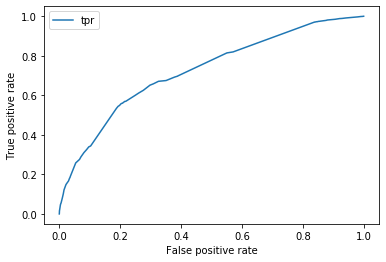

In [112]:
# Uncomment this cell when classifier 3 has been written
#from sklearn import metrics

#fpr, tpr, _ = metrics.roc_curve(test.salary, ratios,pos_label=">50K")

#df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
#plt=df.plot(x="fpr",y="tpr",xlabel="False positive rate", ylabel="True positive rate")
#plt

Try using the `axhline` and `axvline` methods of the `plt` object that you created above to draw horizontal and vertical lines for the TPR and FPR that you calculated above.

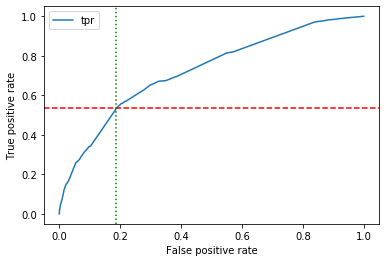

In [116]:
plt.axhline(y=TPR, color='r', linestyle="--")
plt.axvline(x=FPR, color='g', linestyle=":")
plt.figure

The area under the ROC curve is a useful single measure of how good the classifier is. The `roc_auc_score` method can be used to return the area under the curve:

In [118]:
# Uncomment this cell when classifier 3 has been written
#metrics.roc_auc_score(test.salary, ratios)

So, the area under the ROC curve for the Naïve Bayes classifier using just the **education** and **workclass** features is 0.72.

## Using continuous features


For continuous features we must model the data using an appropriate distribution.

Consider the age data in our data set. We can plot the density histogram of this feature for the low and high salary groups.

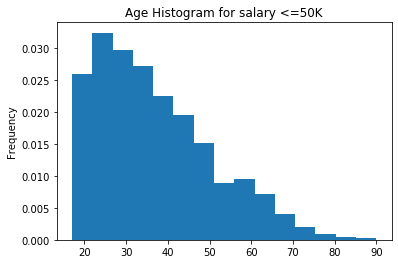

In [119]:
plt1=training.age[training.salary=='<=50K'].plot(kind="hist", bins=15, density=True, ylabel="Density", title="Age Histogram for salary <=50K")


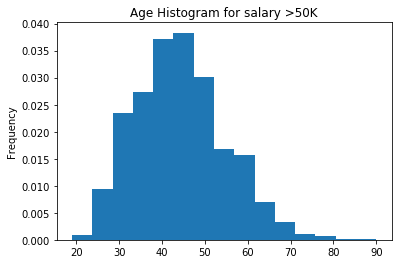

In [120]:
plt2=training.age[training.salary=='>50K'].plot(kind="hist", bins=15, density=True, ylabel="Density", title="Age Histogram for salary >50K")


You can see that there is a clear difference between the two groups although there is considerable overlap.

We wish to model these distributions using the normal distribution.

Using `groupby` we can easily calculate the mean and standard distribution for the two groups:

In [121]:
training.groupby("salary").mean()['age']

salary
<=50K    36.783738
>50K     44.249841
Name: age, dtype: float64

In [122]:
training.groupby("salary").std()['age']

salary
<=50K    14.020088
>50K     10.519028
Name: age, dtype: float64

To see how well the normal distribution matches the data we can plot the normal density curve on the histograms, e.g.,

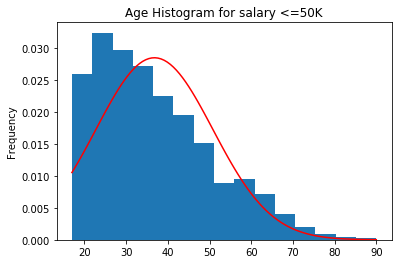

In [123]:
import numpy as np
from scipy.stats import norm

mean=training.groupby("salary").mean()['age']['<=50K']
sd=training.groupby("salary").std()['age']['<=50K']

xmin = training.groupby("salary")['age'].min()['<=50K']
xmax = training.groupby("salary")['age'].max()['<=50K']

x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, sd)
  
plt1.plot(x, p, color='red')
plt1.figure

Do the same for the low Salary age's histogram.

The normal model looks more sensible for the high salary group but is less good a fit for the low salary group. Nonetheless we will carry on with these values and add the age feature into our classifier for illustration.

Adjust your classifier3 to classifier4 to use the age feature:

    Use the method norm.pdf for the normal density function

If it's easier, don't worry about storing the results from the groupby function and indexing them in the code. Feel free to keep things simpler and type the mean and standard deviation numbers into your code for this exercise.

Replot the ROC curve for the new classifier. Does it look better? What is the area under the curve now?


In [125]:
#Insert your code here for classifier4


0.7928390501120648

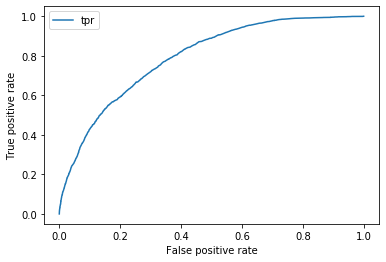

In [126]:
#Insert your code here for getting ratios,predictions, confusion matrix, ROC curve and AUC
